# Read .smr files into Python using NEO

<a id='section1'></a>
## ***(1) Load and Check Python packages***


In [1]:
# load Python modules
!python -m pip install sonpy
!python -m pip install /home/shiva/Downloads/python-neo-0.10.0 ## neo version 10 is not released yet you have to download the release from github

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import neo
import sys
import csv
import os
print("Neo version = ", neo.__version__)
print("Python version = ", sys.version)

# plot the output of matplotlib commands in the notebook
%matplotlib inline

Processing /home/shiva/Downloads/python-neo-0.10.0
  Created wheel for neo: filename=neo-0.10.0-py3-none-any.whl size=548139 sha256=cd728c2c301e08b5844af0eae3fb6882f3177f85ed2cb64e7ed2e3fbcc076866
  Stored in directory: /home/shiva/.cache/pip/wheels/be/3b/df/da74cef4339b70ceedf7bb0e9ff1726c8c942adb6a5e90bdac
Successfully built neo
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tridesclous 1.6.3.dev0 requires numba, which is not installed.
Neo version =  0.10.0
Python version =  3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]


<a id='section2'></a>
##  (2) Read .smr/.smrx file with Neo
##### [back to top](#section1)

### input filepath:

In [2]:
filepath='/home/shiva/Desktop/SquarePulse_k03_D2only_test.smr'
filepath = '/home/shiva/Downloads/Beta STR_s01.smrx'

In [3]:

def read_laser_file(filepath):
    filename = os.path.basename(filepath)
    file_extension = filename.split('.') [-1]
    
    ## Depending on the file extension, the laser information is stored differently
    if file_extension == 'smrx':
        neo_obj = neo.CedIO(filepath)
        analogsignals = read_neo_file_return_analogsignals(neo_obj)
        
        # keep the signal as a 16 bit float
        laser_series = np.float16(analogsignals[1]) # the laser information is stored as the second analog signal
    else:
        neo_obj = neo.Spike2IO(filepath)
        analogsignals = read_neo_file_return_analogsignals(neo_obj)
        
        # keep the signal as a 16 bit float
        laser_series = np.float16(analogsignals[1][:,1]) # the laser information is stored as the second column in the 
                                             # the second analog signal
        
    return laser_series    
def read_neo_file_return_analogsignals(neo_obj):
    
    block = neo_obj.read()[0] # read the file 
    analogsignals = block.segments[0].analogsignals
    report_info_on_file(block, analogsignals)
    
    return analogsignals

def report_info_on_file(block, analogsignals):
    
    print('number of segments = ', len(block.segments))
    print('number of analog signals = ', len(analogsignals))
    for i in range(len(analogsignals)):
        print('signal {} contains {} series'.format(i+1, analogsignals[i].shape))
        
laser_series = read_laser_file(filepath)

number of segments =  1
number of analog signals =  4
signal 1 contains (129501, 1) series
signal 2 contains (129501, 1) series
signal 3 contains (129501, 1) series
signal 4 contains (12950, 1) series


In [4]:

fs = 1000 # sampling rate
laser_threshold = 4 # 
pts = int(np.prod(laser_series.shape)) # number of datapoints
secs = pts/fs # recording length in seconds
time = np.linspace(0, secs, pts)
print('{} data points\n{} sec\n'.format(
        pts, secs))

129501 data points
129.501 sec



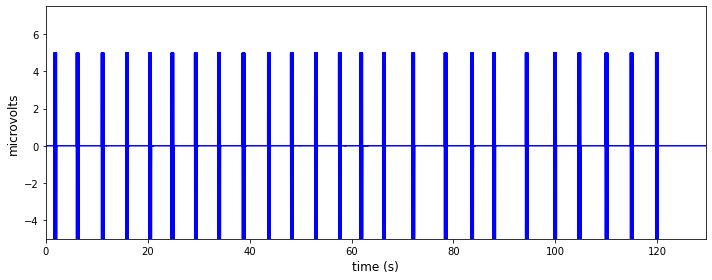

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
miny = np.min(laser_series) ; maxy = np.max(laser_series)* 1.5
ax.plot(time , laser_series, 'b') 
ax.set_xlabel('time (s)', fontsize=12)
ax.set_ylabel('microvolts', fontsize=12)
ax.set_xlim(0, secs)
ax.set_ylim(miny, maxy)
plt.tight_layout()

In [6]:
def laser_start_and_end(laser_series, laser_threshold = 4):
    peaks = (laser_series > laser_threshold).reshape(1,-1)[0]
    peaks = peaks * 1
    shifted_right = np.roll(peaks, 1)
    shifted_left = np.roll(peaks, -1)

    laser_start = np.where(peaks - shifted_right > 0)[0]
    laser_end = np.where(peaks - shifted_left > 0)[0]
    return laser_start, laser_end
laser_start, laser_end = laser_start_and_end(laser_series, laser_threshold = 4)
print('laser starts = \n\n', time[laser_start],
      '\n\n laser ends = \n\n', time[laser_end])

laser starts = 

 [  1.59501232   1.6450127    1.69501309   1.74501347   1.79501386
   1.84501425   1.89501463   1.94501502   1.99501541   2.04501579
   5.97904617   6.02904656   6.07904694   6.12904733   6.17904771
   6.2290481    6.27904849   6.32904887   6.37904926   6.42904964
  10.89308412  10.9430845   10.99308489  11.04308527  11.09308566
  11.14308605  11.19308643  11.24308682  11.2930872   11.34308759
  15.670121    15.72012139  15.77012178  15.82012216  15.87012255
  15.92012293  15.97012332  16.02012371  16.07012409  16.12012448
  20.21915613  20.26915652  20.3191569   20.36915729  20.41915768
  20.46915806  20.51915845  20.56915883  20.61915922  20.66915961
  24.59018988  24.64019027  24.69019066  24.74019104  24.79019143
  24.84019181  24.8901922   24.94019259  24.99019297  25.04019336
  29.17722531  29.22722569  29.27722608  29.32722646  29.37722685
  29.42722724  29.47722762  29.52722801  29.57722839  29.62722878
  33.75926069  33.80926107  33.85926146  33.90926185  33.9

# Plot one stimulation:

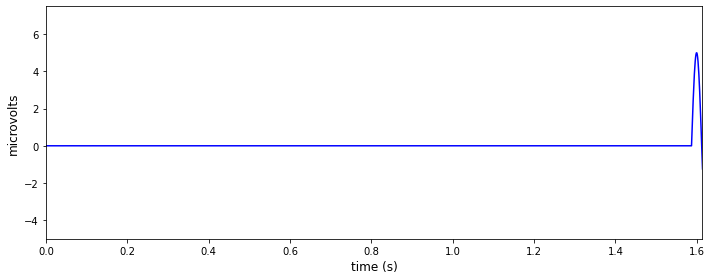

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
miny = np.min(laser_series) ; maxy = np.max(laser_series)* 1.5
ax.plot(time , laser_series, 'b') 
ax.set_xlabel('time (s)', fontsize=12)
ax.set_ylabel('microvolts', fontsize=12)

first_laser_duration = time[laser_end[0]] - time[laser_start[0]]
ax.set_xlim(0, time[laser_end[0]] + first_laser_duration)
ax.set_ylim(miny, maxy)
plt.tight_layout()

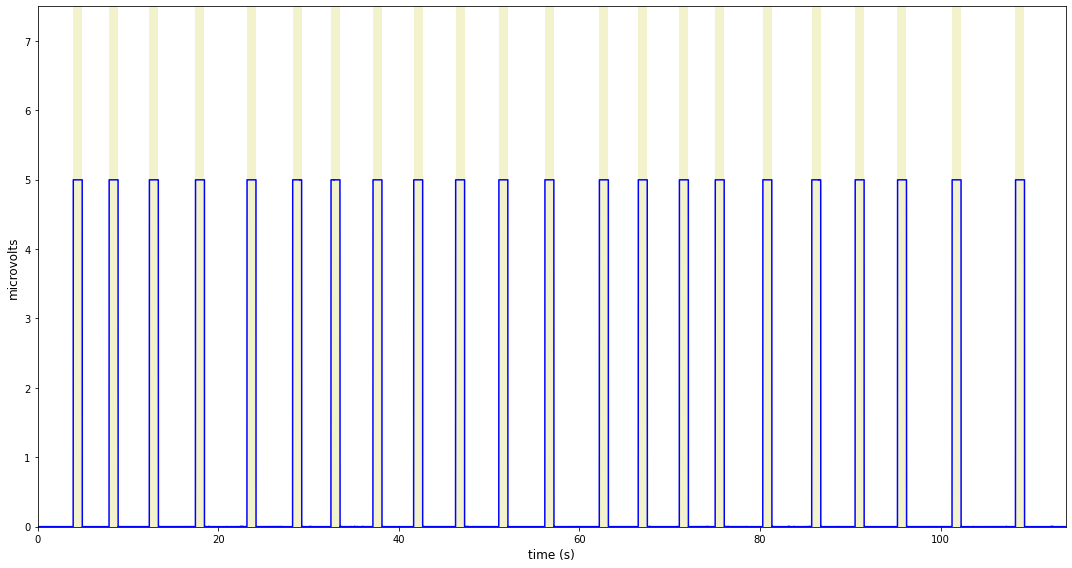

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
miny = np.min(laser_series) ; maxy = np.max(laser_series)* 1.5
ax.plot(time , laser_series, 'b') 
ax.set_xlabel('time (s)', fontsize=12)
ax.set_ylabel('microvolts', fontsize=12)
ax.set_xlim(0, secs)
ax.set_ylim(miny, maxy)
plt.tight_layout()

for (start, end) in zip(laser_start,laser_end):
    plt.axvspan(time[start], time[end],  facecolor='y', alpha=0.2)

# (3) Save laser stampts skipping rows as before

In [36]:
def save_laser_stamps_to_csv(filepath, laser_start, laser_end):
    
    metadatas=[[filepath],
                ["framerate : "],
                ["csv_aligned :", 'NO'],
               ["first_laser_time : ", 'None']
               ]
    df = pd.DataFrame(np.concatenate((laser_start.reshape(-1,1), laser_end.reshape(-1,1)),
                                      axis = 1) , 
                      columns = ['ON', 'OFF'])
    resultFilePath = filepath.replace(os.path.splitext(filename)[1], '.csv')
    with open(resultFilePath, 'w') as resultfile:

        csvResult=csv.writer(resultfile,delimiter=',', lineterminator='\n')
        csvResult.writerows(metadatas)

    df.to_csv(resultFilePath, mode = 'a', index = False)
save_laser_stamps_to_csv(filepath, laser_start, laser_end)